# 探索数据

- 用户特征
- 视频特征
- 交互数据

基本探索思路：
1. 加载数据，检查能否正常加载数据
2. 查看数据基本信息，如有哪些数据列(`df.columns`)，数据的形状(`df.shape`)，数据列的类型(`df.dtypes`或`df.info()`)，数据的基本统计信息(`df.describe()`)
3. 处理null值，填补null值或者丢弃null值所在的行
4. 删除重复数据
5. 检查各个列(属性)的分布，可以通过画图来分析

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from collections import Counter
from sklearn.feature_extraction import FeatureHasher
from sklearn.preprocessing import StandardScaler

pd.set_option('display.float_format', lambda x: f"{x:.3f}")

In [2]:
base_dir = "./2021_3_data"
test_data_dir  = os.path.join(base_dir, "testdata")
train_data_dir = os.path.join(base_dir, "traindata")

In [3]:
train_dirs = os.listdir(train_data_dir)
test_dirs  = os.listdir(test_data_dir)
print(train_dirs,'\n', test_dirs)

['history_behavior_data', 'user_features_data', 'video_features_data'] 
 ['test.csv']


## 用户特征

In [4]:
# 加载数据
user_data = pd.read_csv(os.path.join(train_data_dir, "user_features_data/user_features_data.csv"), delimiter="\t")

In [5]:
# 查看数据基本信息
print(user_data.columns.tolist())
print(user_data.shape)
user_data.head(5)

['user_id', 'age', 'gender', 'country', 'province', 'city', 'city_level', 'device_name']
(5910800, 8)


,user_id,age,gender,country,province,city,city_level,device_name
0,1757005,3,1,0,9,6,3,327
1,17938,0,0,0,4,22,3,327
2,4263520,1,0,0,19,1,5,327
3,1411600,3,0,0,5,138,1,327
4,3992242,2,0,0,0,142,0,327


In [6]:
user_data.info()
user_data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5910800 entries, 0 to 5910799
Data columns (total 8 columns):
 #   Column       Dtype
---  ------       -----
 0   user_id      int64
 1   age          int64
 2   gender       int64
 3   country      int64
 4   province     int64
 5   city         int64
 6   city_level   int64
 7   device_name  int64
dtypes: int64(8)
memory usage: 360.8 MB


,user_id,age,gender,country,province,city,city_level,device_name
count,5910800.000,5910800.000,5910800.000,5910800.000,5910800.000,5910800.000,5910800.000,5910800.000
mean,2955399.500,1.886,0.285,0.001,9.176,86.034,2.057,72.104
std,1706301.130,1.564,0.478,0.030,7.878,81.779,1.662,79.275
min,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,1477699.750,0.000,0.000,0.000,2.000,17.000,1.000,17.000
50%,2955399.500,2.000,0.000,0.000,7.000,59.000,2.000,46.000
75%,4433099.250,3.000,1.000,0.000,15.000,137.000,3.000,102.000
max,5910799.000,7.000,3.000,2.000,32.000,338.000,7.000,1825.000


In [7]:
col_null = user_data.apply(lambda x: sum(x.isnull()), axis=0)
# row_null = user_data.apply(lambda x: sum(x.isnull()), axis=1)

In [8]:
print(f"各列中存在null值的数量：\n{col_null}")
# print(f"存在null值的行数：{sum(row_null != 0)}")

各列中存在null值的数量：
user_id        0
age            0
gender         0
country        0
province       0
city           0
city_level     0
device_name    0
dtype: int64


In [9]:
# 丢弃重复的行
user_data.drop_duplicates(inplace=True)

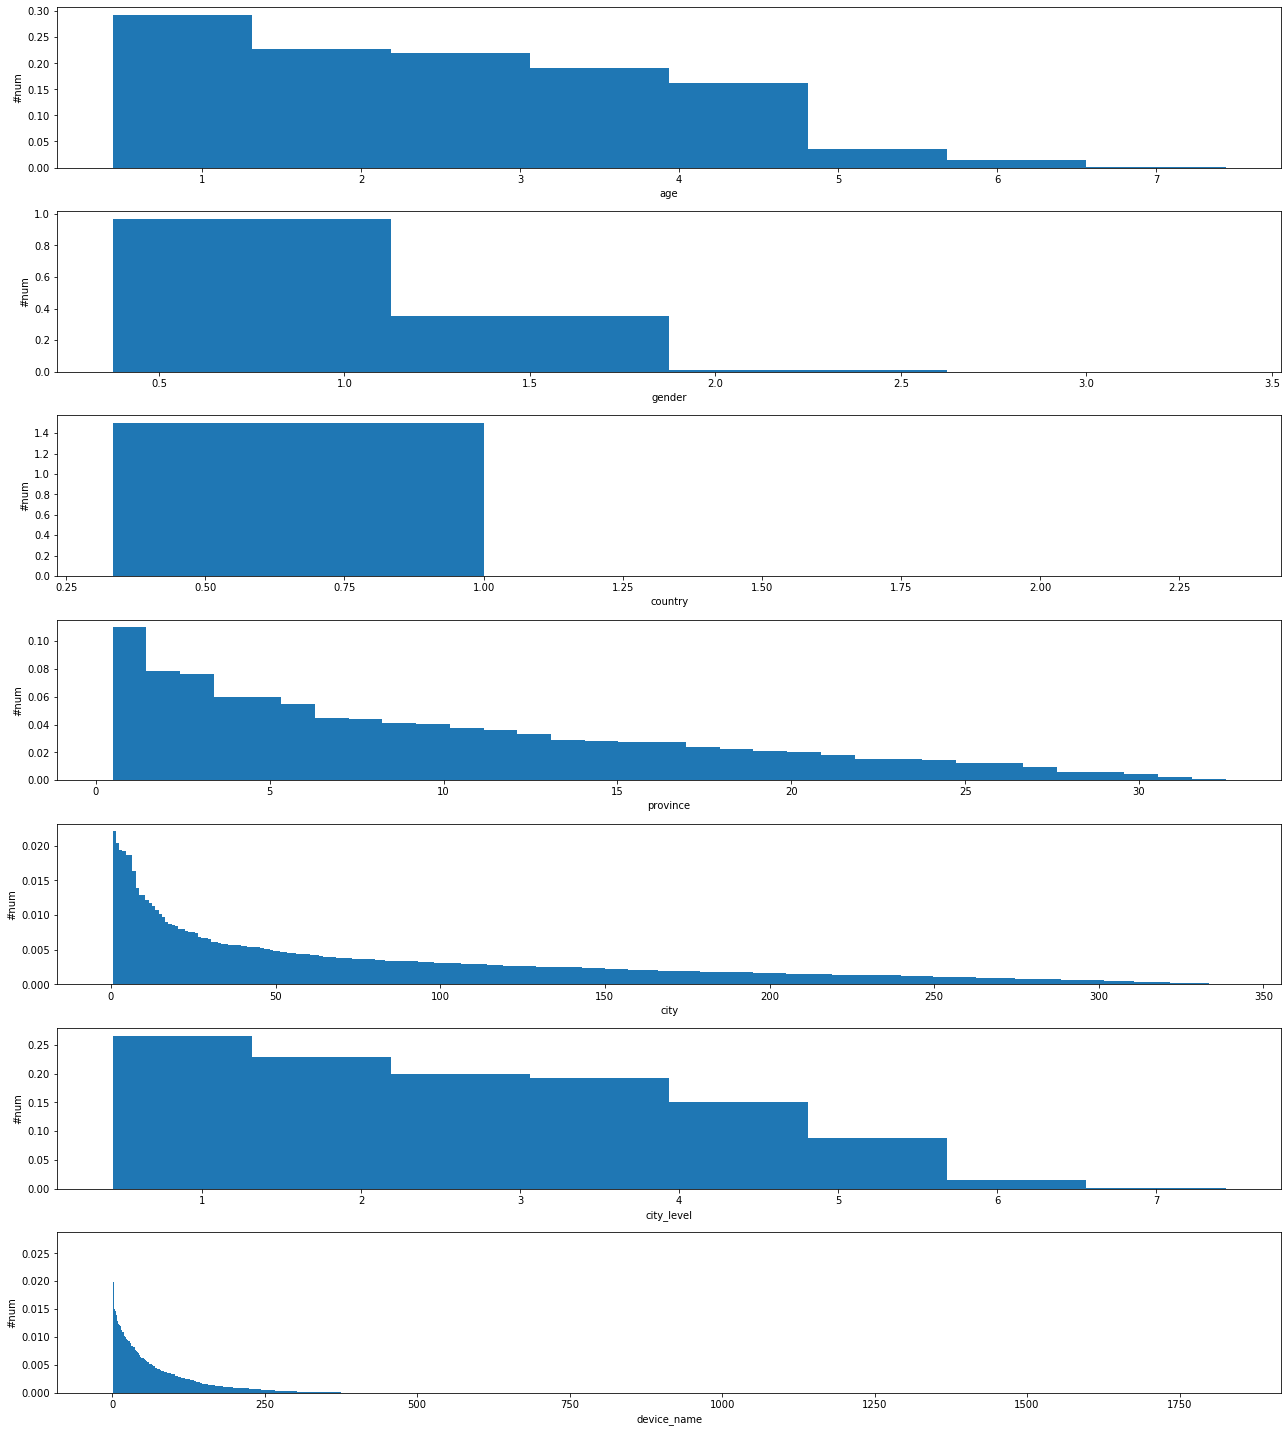

In [38]:
# 分析各个特征的分布
cols = user_data.columns.tolist()[1:]  # 去掉id列
fid, axes = plt.subplots(len(cols), 1, figsize=(18,20))

for idx, col in enumerate(cols):
    bins = len(user_data[col].unique())
    n, *_ = axes[idx].hist(user_data[col], bins=bins, align='right', density=True, log=False)
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel("#num")
#     print(f"{col} : {Counter(user_data[col])}, {[e/sum(n) for e in n]}")

plt.tight_layout()
plt.show()

## 视频特征

In [90]:
video_data = pd.read_csv(os.path.join(train_data_dir, "video_features_data/video_features_data.csv"), delimiter="\t")

In [12]:
print(video_data.shape)
print(video_data.columns.tolist())
video_data.head(5)

(49731, 10)
['video_id', 'video_name', 'video_tags', 'video_description', 'video_release_date', 'video_director_list', 'video_actor_list', 'video_score', 'video_second_class', 'video_duration']


,video_id,video_name,video_tags,video_description,video_release_date,video_director_list,video_actor_list,video_score,video_second_class,video_duration
0,3460,脱皮爸爸,"院线电影,家庭关系,命运","中年失意的儿子田力行（古天乐饰）在生活上遇到了重重危机：母亲病逝,工作不顺,妻子要求离婚。正...",2017-04-27,司徒慧焯,"吴镇宇,古天乐,春夏,蔡洁",7.400,"剧情,喜剧,奇幻",5913
1,14553,喜气洋洋小金莲,"古装喜剧,剧情片,喜剧片,内地电影,欢乐喜剧,爱情纠纷",故事始于西门庆为西门药业的“伟哥”产品寻找代言人，西门庆初见潘金莲，一时惊为天人，为成功抱得...,2015-12-30,"杨珊珊,李亚玲","陈南飞,程隆妮,王闯,贾海涛,闫薇儿",5.600,喜剧,6217
2,1214,风流家族,"男女关系,家庭关系,命运,院线电影",香世仁（钟镇涛 饰）是家财万贯的香港富豪，在满足了一切物质上的要求后，他将生活的重心放在了儿...,2002-03-07,"邱礼涛,杨漪珊","张家辉,卢巧音,钟镇涛,叶童,李蕙敏,张坚庭,袁洁莹,黄佩霞,齐芷瑶,刘以达,叶伟信,邹凯光...",6.800,"都市,喜剧,爱情,家庭",5963
3,30639,大提琴的故事,"短片,动画片",低音大提琴演奏家史密斯科夫正要去参加某贵族的沙龙，途中他被河边的美丽景色所吸引，驻足观看。兴...,1949-01-01,"伊里·特恩卡,契诃夫",NaN,nan,"动画,爱情",17371
4,38522,歌舞大王齐格飞,"喜剧片,人物传记,浪漫爱情",罗伯特．Z．伦纳德导演的这部影片以百老汇最大的歌舞团——齐格菲歌舞团的创办人佛罗伦斯．齐格菲...,1936-04-08,"罗伯特·Z·伦纳德,William Anthony McGuire","威廉·鲍威尔,玛娜·洛伊,路易丝·赖纳,弗兰克·摩根,范妮·布莱斯,弗吉尼亚·布鲁斯,雷吉纳...",7.700,"剧情,歌舞,喜剧",10608


In [13]:
video_data.info()
video_data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49731 entries, 0 to 49730
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   video_id             49731 non-null  int64  
 1   video_name           49722 non-null  object 
 2   video_tags           41831 non-null  object 
 3   video_description    49536 non-null  object 
 4   video_release_date   49061 non-null  object 
 5   video_director_list  38728 non-null  object 
 6   video_actor_list     39543 non-null  object 
 7   video_score          46417 non-null  float64
 8   video_second_class   43821 non-null  object 
 9   video_duration       49731 non-null  int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 3.8+ MB


,video_id,video_score,video_duration
count,49731.000,46417.000,49731.000
mean,25170.854,7.361,3675.074
std,14540.777,0.819,2862.818
min,0.000,5.000,0.000
25%,12579.500,7.000,148.000
50%,25161.000,7.400,5029.000
75%,37766.500,7.900,5817.000
max,50354.000,9.800,23536.000


In [29]:
col_null = video_data.apply(lambda x: sum(x.isnull()), axis=0)

In [30]:
col_null / video_data.shape[0]

video_id              0.000
video_name            0.000
video_tags            0.159
video_description     0.004
video_release_date    0.013
video_director_list   0.221
video_actor_list      0.205
video_score           0.067
video_second_class    0.119
video_duration        0.000
dtype: float64

## 交互数据

In [14]:
action_dirs = os.listdir(os.path.join(train_data_dir, "history_behavior_data"))
action_files = {e: os.listdir(os.path.join(train_data_dir, f"history_behavior_data/{e}"))[0] for e in action_dirs}
print(action_files)

{'20210419': 'part-00000-236b99d5-456a-42b2-bd8d-3cbd61d21cc6-c000.csv', '20210420': 'part-00000-aad75aa4-b60b-4f5b-8def-c4d60f391fae-c000.csv', '20210421': 'part-00000-c15f29da-6b1e-48c0-b7d0-2cd560998c3f-c000.csv', '20210422': 'part-00000-3d97d0f8-2572-45e6-bb60-f367c97e7870-c000.csv', '20210423': 'part-00000-9809d73a-a55f-4ac2-a59b-9b83cbc5028e-c000.csv', '20210424': 'part-00000-225e55dc-4504-4c14-b289-322312355b2b-c000.csv', '20210425': 'part-00000-9d23862b-6bbf-48c6-a598-572df1359737-c000.csv', '20210426': 'part-00000-0d315342-3ba7-4727-b4a2-123a1a004786-c000.csv', '20210427': 'part-00000-9132ab46-51c3-4cc3-97de-e7ad5312b852-c000.csv', '20210428': 'part-00000-fc8c8ca1-e655-4a45-b179-c8d9e2dd804c-c000.csv', '20210429': 'part-00000-c5dbd994-54d7-4734-adea-0f22d75b23d3-c000.csv', '20210430': 'part-00000-2da4c3a0-2fcc-422d-8b7c-48940da315ad-c000.csv', '20210501': 'part-00000-56b6f0ff-57b8-41ac-96ec-c20e3306297e-c000.csv', '20210502': 'part-00000-d412c602-2f4a-4649-a81f-e56435dd49fd-c0

In [15]:
i = action_dirs[1]
action_data = pd.read_csv(os.path.join(train_data_dir, f"history_behavior_data/{i}/{action_files[i]}"), delimiter="\t")

d:\codeprograms\python37\lib\site-packages\IPython\core\interactiveshell.py:3147: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [16]:
print(action_data.shape)
print(action_data.columns.tolist())
action_data.head(5)

(5511348, 9)
['user_id', 'video_id', 'is_watch', 'is_share', 'is_collect', 'is_comment', 'watch_start_time', 'watch_label', 'pt_d']


,user_id,video_id,is_watch,is_share,is_collect,is_comment,watch_start_time,watch_label,pt_d
0,2543081,5035,0,0,0,0,NaN,0,20210420
1,2543081,9527,0,0,0,0,NaN,0,20210420
2,2543081,3717,0,0,0,0,NaN,0,20210420
3,2543081,37417,0,0,0,0,NaN,0,20210420
4,2543081,28368,0,0,0,0,NaN,0,20210420


In [17]:
action_data.info()
# action_data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5511348 entries, 0 to 5511347
Data columns (total 9 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   user_id           int64 
 1   video_id          int64 
 2   is_watch          int64 
 3   is_share          int64 
 4   is_collect        int64 
 5   is_comment        int64 
 6   watch_start_time  object
 7   watch_label       int64 
 8   pt_d              int64 
dtypes: int64(8), object(1)
memory usage: 378.4+ MB


In [18]:
# 按照 (user_id, video_id)进行分组。绝大部分用户基本只看了一个视频
d = action_data.duplicated(['user_id', 'video_id'])

In [19]:
d = d[d]
print(f"重复的(user_id, video_id)数量 : {d.shape[0]} ({d.shape[0]/action_data.shape[0]})")

重复的(user_id, video_id)数量 : 25 (4.536095343643697e-06)


In [20]:
# 统计每个用户的行为数目
# nu = action_data['user_id']

In [21]:
col_null = action_data.apply(lambda x: sum(x.isnull()), axis=0)

In [22]:
col_null / action_data.shape[0] # 可见，watch_start_time大部分都为NaN

user_id            0.000
video_id           0.000
is_watch           0.000
is_share           0.000
is_collect         0.000
is_comment         0.000
watch_start_time   0.907
watch_label        0.000
pt_d               0.000
dtype: float64

In [23]:
# 删除列
action_data.drop('watch_start_time', inplace=True, axis=1)
action_data.drop('pt_d', inplace=True, axis=1)

is_watch : Counter({0: 5000945, 1: 510403}), [0.907, 0.093]
is_share : Counter({0: 5510400, 1: 948}), [1.0, 0.0]
is_collect : Counter({0: 5505237, 1: 6111}), [0.999, 0.001]
is_comment : Counter({0: 5510385, 1: 963}), [1.0, 0.0]
watch_label : Counter({0: 5363875, 1: 36171, 9: 28097, 2: 20349, 3: 14991, 4: 11810, 5: 9820, 8: 9375, 6: 8793, 7: 8067}), [0.973, 0.007, 0.004, 0.003, 0.002, 0.002, 0.002, 0.001, 0.002, 0.005]


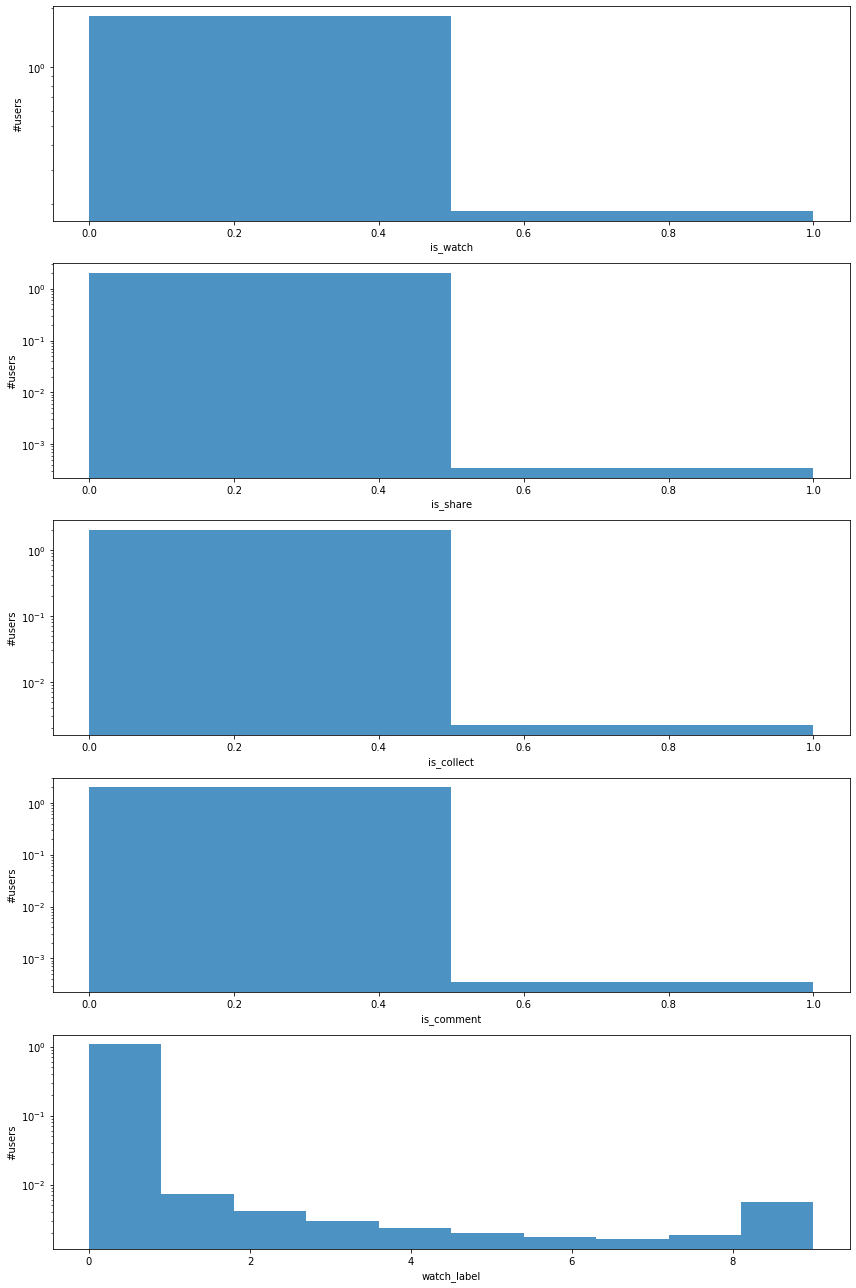

In [53]:
# 分析各个特征的分布
cols = action_data.columns.tolist()[2:]  # 去掉id列
# cols.remove('watch_start_time')
# cols.remove('pt_d')
fid, axes = plt.subplots(len(cols), 1, figsize=(12,18))



for idx, col in enumerate(cols):
    bins = len(action_data[col].unique())
    n, *_ = axes[idx].hist(action_data[col], bins=bins, align='mid', density=True, alpha=0.8, log=True)
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel("#users")
    print(f"{col} : {Counter(action_data[col])}, {[round(e/sum(n), 3) for e in n]}")

plt.tight_layout()
plt.show()

## 测试数据

In [25]:
test_data = pd.read_csv(os.path.join(test_data_dir, "test.csv"))

In [26]:
print(test_data.shape)
print(test_data.columns.tolist())
test_data.head(5)

(2822180, 2)
['user_id', 'video_id']


,user_id,video_id
0,1688013,32645
1,4502598,41270
2,5585629,16345
3,1635520,28149
4,4160191,40554


In [27]:
print(f"unique users  : {len(test_data['user_id'].unique())}")
print(f"unique videos : {len(test_data['video_id'].unique())}")

unique users  : 492174
unique videos : 23686


In [28]:
# 检查测试数据中的(user_id, video_id)是否出现在历史行为数据中
pd.merge(action_data, test_data, on=['user_id', 'video_id'], how='inner')

,user_id,video_id,is_watch,is_share,is_collect,is_comment,watch_label
0,4206081,12968,0,0,0,0,0
1,2828977,1759,0,0,0,0,0
2,3861990,23410,0,0,0,0,0
3,1093230,29453,0,0,0,0,0
4,1093230,28413,0,0,0,0,0
...,...,...,...,...,...,...,...
26767,3944251,50299,1,0,1,1,0
26768,5614611,47507,1,0,0,0,0
26769,5614611,15888,1,0,0,0,7
26770,3218613,5601,1,0,0,0,7


In [29]:
action_data[(action_data['user_id'] == 1869184) & (action_data['video_id'] == 12968)]

,user_id,video_id,is_watch,is_share,is_collect,is_comment,watch_label


In [30]:
test_data[(test_data['user_id'] == 1869184) & (test_data['video_id'] == 12968)]

,user_id,video_id
951388,1869184,12968


# 生成初步的特征矩阵

## 用户特征矩阵

In [5]:
user_data

,user_id,age,gender,country,province,city,city_level,device_name
0,1757005,3,1,0,9,6,3,327
1,17938,0,0,0,4,22,3,327
2,4263520,1,0,0,19,1,5,327
3,1411600,3,0,0,5,138,1,327
4,3992242,2,0,0,0,142,0,327
...,...,...,...,...,...,...,...,...
5910795,3223427,4,0,0,3,3,3,28
5910796,4707826,4,0,0,17,249,1,28
5910797,5907653,0,0,0,11,65,0,28
5910798,3633224,3,0,0,2,57,1,28


In [6]:
# 各特征的基数
cols = user_data.columns[1:]
for col in cols:
    print(f"{col:12} : {user_data[col].unique().shape[0]:^6}")

age          :   8   
gender       :   4   
country      :   3   
province     :   33  
city         :  339  
city_level   :   8   
device_name  :  1826 


### 用户数据中类别特征的转化

基数很大的类别特征['province', 'city', 'device_name']

- 删除以下列：`['province', 'city']`
- 展开为one-hot：`['age', 'gender', 'city_level']`
- 用 FeatureHasher处理：`['device_name']`


In [7]:
del_cols = ['province', 'city', 'country']
for dc in del_cols: 
    user_data.drop([dc], axis=1, inplace=True)
    
user_data.head(5)

,user_id,age,gender,city_level,device_name
0,1757005,3,1,3,327
1,17938,0,0,3,327
2,4263520,1,0,5,327
3,1411600,3,0,1,327
4,3992242,2,0,0,327


In [8]:
onehot_cols = ['age', 'gender', 'city_level']

for oc in onehot_cols:
    df = user_data[oc]
    tmp_df = pd.get_dummies(df)
    cols = tmp_df.columns
    tmp_df.columns = [f"{oc}_{col}" for col in cols]
    user_data = pd.concat([user_data, tmp_df], axis=1)
    print(f"{oc} processed ...")
    user_data.drop([oc], axis=1, inplace=True)
    del tmp_df
user_data.head(5)

age processed ...
gender processed ...
city_level processed ...


,user_id,device_name,age_0,age_1,age_2,age_3,age_4,age_5,age_6,age_7,...,gender_2,gender_3,city_level_0,city_level_1,city_level_2,city_level_3,city_level_4,city_level_5,city_level_6,city_level_7
0,1757005,327,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,17938,327,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,4263520,327,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,1411600,327,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,3992242,327,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [9]:
fh_cols = ['device_name']
n_feats = [10]
for idx, fc in enumerate(fh_cols):
#     df = user_data[fc]
    fea_hs = FeatureHasher(n_features=n_feats[idx], input_type='string')
    hasherd = fea_hs.fit_transform(user_data[fc].astype('str'))
    tmp_df = pd.DataFrame(hasherd.toarray(), columns=[f"{fc}_{i}" for i in range(n_feats[idx])])
    user_data = pd.concat([user_data, tmp_df], axis=1)
    print(f"{fc} processed ...")
    user_data.drop([fc], axis=1, inplace=True)
    del hasherd
    
user_data.head(5)

device_name processed ...


,user_id,age_0,age_1,age_2,age_3,age_4,age_5,age_6,age_7,gender_0,...,device_name_0,device_name_1,device_name_2,device_name_3,device_name_4,device_name_5,device_name_6,device_name_7,device_name_8,device_name_9
0,1757005,0,0,0,1,0,0,0,0,0,...,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000
1,17938,1,0,0,0,0,0,0,0,1,...,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000
2,4263520,0,1,0,0,0,0,0,0,1,...,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000
3,1411600,0,0,0,1,0,0,0,0,1,...,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000
4,3992242,0,0,1,0,0,0,0,0,1,...,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000


In [10]:
user_data.describe()

,user_id,age_0,age_1,age_2,age_3,age_4,age_5,age_6,age_7,gender_0,...,device_name_0,device_name_1,device_name_2,device_name_3,device_name_4,device_name_5,device_name_6,device_name_7,device_name_8,device_name_9
count,5910800.000,5910800.000,5910800.000,5910800.000,5910800.000,5910800.000,5910800.000,5910800.000,5910800.000,5910800.000,...,5910800.000,5910800.000,5910800.000,5910800.000,5910800.000,5910800.000,5910800.000,5910800.000,5910800.000,5910800.000
mean,2955399.500,0.257,0.198,0.192,0.167,0.142,0.031,0.013,0.001,0.726,...,0.567,0.431,-0.193,-0.146,0.000,0.000,0.000,-0.442,0.155,-0.159
std,1706301.130,0.437,0.399,0.394,0.373,0.349,0.173,0.112,0.029,0.446,...,0.646,0.599,0.419,0.367,0.000,0.000,0.000,0.610,0.378,0.378
min,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,-3.000,-3.000,0.000,0.000,0.000,-4.000,0.000,-3.000
25%,1477699.750,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-1.000,0.000,0.000
50%,2955399.500,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
75%,4433099.250,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,...,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
max,5910799.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,...,3.000,3.000,0.000,0.000,0.000,0.000,0.000,0.000,3.000,0.000


### 对特征列进行标准化

In [11]:
cols = user_data.columns[1:]
scaler = StandardScaler()
data = user_data[cols]
scaler.fit(data)
sca_data = scaler.transform(data)

In [12]:
user_data[cols] = sca_data

In [13]:
user_data.head(10)

,user_id,age_0,age_1,age_2,age_3,age_4,age_5,age_6,age_7,gender_0,...,device_name_0,device_name_1,device_name_2,device_name_3,device_name_4,device_name_5,device_name_6,device_name_7,device_name_8,device_name_9
0,1757005,-0.588,-0.497,-0.487,2.235,-0.407,-0.178,-0.113,-0.029,-1.628,...,0.670,0.950,0.462,0.396,0.000,0.000,0.000,0.725,2.237,0.421
1,17938,1.701,-0.497,-0.487,-0.448,-0.407,-0.178,-0.113,-0.029,0.614,...,0.670,0.950,0.462,0.396,0.000,0.000,0.000,0.725,2.237,0.421
2,4263520,-0.588,2.011,-0.487,-0.448,-0.407,-0.178,-0.113,-0.029,0.614,...,0.670,0.950,0.462,0.396,0.000,0.000,0.000,0.725,2.237,0.421
3,1411600,-0.588,-0.497,-0.487,2.235,-0.407,-0.178,-0.113,-0.029,0.614,...,0.670,0.950,0.462,0.396,0.000,0.000,0.000,0.725,2.237,0.421
4,3992242,-0.588,-0.497,2.052,-0.448,-0.407,-0.178,-0.113,-0.029,0.614,...,0.670,0.950,0.462,0.396,0.000,0.000,0.000,0.725,2.237,0.421
5,4011597,-0.588,-0.497,2.052,-0.448,-0.407,-0.178,-0.113,-0.029,0.614,...,0.670,0.950,0.462,0.396,0.000,0.000,0.000,0.725,2.237,0.421
6,4785561,-0.588,-0.497,-0.487,-0.448,-0.407,5.618,-0.113,-0.029,-1.628,...,0.670,0.950,0.462,0.396,0.000,0.000,0.000,0.725,2.237,0.421
7,5110362,1.701,-0.497,-0.487,-0.448,-0.407,-0.178,-0.113,-0.029,0.614,...,0.670,0.950,0.462,0.396,0.000,0.000,0.000,0.725,2.237,0.421
8,1321200,-0.588,-0.497,-0.487,-0.448,-0.407,5.618,-0.113,-0.029,-1.628,...,0.670,0.950,0.462,0.396,0.000,0.000,0.000,0.725,2.237,0.421
9,3206983,1.701,-0.497,-0.487,-0.448,-0.407,-0.178,-0.113,-0.029,-1.628,...,0.670,0.950,0.462,0.396,0.000,0.000,0.000,0.725,2.237,0.421


In [13]:
user_data.info()
user_data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5910800 entries, 0 to 5910799
Data columns (total 31 columns):
 #   Column         Dtype  
---  ------         -----  
 0   user_id        int64  
 1   age_0          float64
 2   age_1          float64
 3   age_2          float64
 4   age_3          float64
 5   age_4          float64
 6   age_5          float64
 7   age_6          float64
 8   age_7          float64
 9   gender_0       float64
 10  gender_1       float64
 11  gender_2       float64
 12  gender_3       float64
 13  city_level_0   float64
 14  city_level_1   float64
 15  city_level_2   float64
 16  city_level_3   float64
 17  city_level_4   float64
 18  city_level_5   float64
 19  city_level_6   float64
 20  city_level_7   float64
 21  device_name_0  float64
 22  device_name_1  float64
 23  device_name_2  float64
 24  device_name_3  float64
 25  device_name_4  float64
 26  device_name_5  float64
 27  device_name_6  float64
 28  device_name_7  float64
 29  device_name_8 

,user_id,age_0,age_1,age_2,age_3,age_4,age_5,age_6,age_7,gender_0,...,device_name_0,device_name_1,device_name_2,device_name_3,device_name_4,device_name_5,device_name_6,device_name_7,device_name_8,device_name_9
count,5910800.000,5910800.000,5910800.000,5910800.000,5910800.000,5910800.000,5910800.000,5910800.000,5910800.000,5910800.000,...,5910800.000,5910800.000,5910800.000,5910800.000,5910800.000,5910800.000,5910800.000,5910800.000,5910800.000,5910800.000
mean,2955399.500,-0.000,-0.000,-0.000,-0.000,-0.000,0.000,0.000,0.000,-0.000,...,0.000,0.000,-0.000,-0.000,0.000,0.000,0.000,-0.000,0.000,-0.000
std,1706301.130,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,...,1.000,1.000,1.000,1.000,0.000,0.000,0.000,1.000,1.000,1.000
min,0.000,-0.588,-0.497,-0.487,-0.448,-0.407,-0.178,-0.113,-0.029,-1.628,...,-0.879,-0.720,-6.702,-7.778,0.000,0.000,0.000,-5.832,-0.410,-7.505
25%,1477699.750,-0.588,-0.497,-0.487,-0.448,-0.407,-0.178,-0.113,-0.029,-1.628,...,-0.879,-0.720,0.462,0.396,0.000,0.000,0.000,-0.914,-0.410,0.421
50%,2955399.500,-0.588,-0.497,-0.487,-0.448,-0.407,-0.178,-0.113,-0.029,0.614,...,-0.879,-0.720,0.462,0.396,0.000,0.000,0.000,0.725,-0.410,0.421
75%,4433099.250,1.701,-0.497,-0.487,-0.448,-0.407,-0.178,-0.113,-0.029,0.614,...,0.670,0.950,0.462,0.396,0.000,0.000,0.000,0.725,-0.410,0.421
max,5910799.000,1.701,2.011,2.052,2.235,2.457,5.618,8.841,34.788,0.614,...,3.768,4.291,0.462,0.396,0.000,0.000,0.000,0.725,7.531,0.421


In [25]:
# 保存数据
data = user_data.values
cols = user_data.columns
np.savez(os.path.join(train_data_dir, "user_features_data/user_features"), features=data, columns=cols)

## 视频特征矩阵

In [28]:
video_data.head()

,video_id,video_name,video_tags,video_description,video_release_date,video_director_list,video_actor_list,video_score,video_second_class,video_duration
0,3460,脱皮爸爸,"院线电影,家庭关系,命运","中年失意的儿子田力行（古天乐饰）在生活上遇到了重重危机：母亲病逝,工作不顺,妻子要求离婚。正...",2017-04-27,司徒慧焯,"吴镇宇,古天乐,春夏,蔡洁",7.400,"剧情,喜剧,奇幻",5913
1,14553,喜气洋洋小金莲,"古装喜剧,剧情片,喜剧片,内地电影,欢乐喜剧,爱情纠纷",故事始于西门庆为西门药业的“伟哥”产品寻找代言人，西门庆初见潘金莲，一时惊为天人，为成功抱得...,2015-12-30,"杨珊珊,李亚玲","陈南飞,程隆妮,王闯,贾海涛,闫薇儿",5.600,喜剧,6217
2,1214,风流家族,"男女关系,家庭关系,命运,院线电影",香世仁（钟镇涛 饰）是家财万贯的香港富豪，在满足了一切物质上的要求后，他将生活的重心放在了儿...,2002-03-07,"邱礼涛,杨漪珊","张家辉,卢巧音,钟镇涛,叶童,李蕙敏,张坚庭,袁洁莹,黄佩霞,齐芷瑶,刘以达,叶伟信,邹凯光...",6.800,"都市,喜剧,爱情,家庭",5963
3,30639,大提琴的故事,"短片,动画片",低音大提琴演奏家史密斯科夫正要去参加某贵族的沙龙，途中他被河边的美丽景色所吸引，驻足观看。兴...,1949-01-01,"伊里·特恩卡,契诃夫",NaN,NaN,"动画,爱情",17371
4,38522,歌舞大王齐格飞,"喜剧片,人物传记,浪漫爱情",罗伯特．Z．伦纳德导演的这部影片以百老汇最大的歌舞团——齐格菲歌舞团的创办人佛罗伦斯．齐格菲...,1936-04-08,"罗伯特·Z·伦纳德,William Anthony McGuire","威廉·鲍威尔,玛娜·洛伊,路易丝·赖纳,弗兰克·摩根,范妮·布莱斯,弗吉尼亚·布鲁斯,雷吉纳...",7.700,"剧情,歌舞,喜剧",10608


### 视频数据中的特征
以下特征中存在nan值：
- video_tags(0.159)
- video_description(0.004)
- video_release_date(0.013)
- video_director_list(0.221)
- video_actor_list(0.205)
- video_score(0.067)
- video_second_class(0.119)

除去id列，有三种类型的特征：
- 文本特征 : `video_name`,`video_tags`,`video_description`,`video_director_list`,`video_actor_list`,`video_second_class`
- 时间特征 : `video_release_date`
- 数值类型特征 : `video_score`, `video_duration`

### 处理nan值
字符特征用空字符串填充，video_score用均值替代

In [91]:
null_cols = col_null[col_null != 0].index.tolist()
# 获取video_score非nan的视频的平均分
mean_score = video_data['video_score'].mean()
nan_rep = ['', '', '', '', '', '', mean_score, '']
print(f"存在null值的列 : {null_cols}")

存在null值的列 : ['video_name', 'video_tags', 'video_description', 'video_release_date', 'video_director_list', 'video_actor_list', 'video_score', 'video_second_class']


In [92]:
for nc, rep in zip(null_cols, nan_rep):
    video_data[nc].fillna(rep, inplace=True)

### 处理时间特诊


In [93]:
video_data['video_release_date'] = pd.to_datetime(video_data['video_release_date'])
video_data['video_release_year'] = video_data['video_release_date'].dt.year
video_data['video_release_month'] = video_data['video_release_date'].dt.month
video_data['video_release_day'] = video_data['video_release_date'].dt.day
video_data.drop('video_release_date', axis=1, inplace=True)  # 删除原来的视频发布日期特征

In [101]:
# 将原来为nan的日期进行填补，随机从非nan中选取值
time_null_cols = ['video_release_year', 'video_release_month', 'video_release_day']
for nc in time_null_cols:
    null_index = video_data[nc].isna()
    video_data.loc[null_index, nc] = np.random.choice(video_data[nc][~null_index], null_index.sum())  # 逻辑非：~
video_data.describe()

,video_id,video_score,video_duration,video_release_year,video_release_month,video_release_day
count,49731.000,49731.000,49731.000,49731.000,49731.000,49731.000
mean,25170.854,7.361,3675.074,2000.644,4.868,10.649
std,14540.777,0.792,2862.818,21.504,3.879,9.837
min,0.000,5.000,0.000,1887.000,1.000,1.000
25%,12579.500,7.000,148.000,1994.000,1.000,1.000
50%,25161.000,7.361,5029.000,2010.000,4.000,8.000
75%,37766.500,7.900,5817.000,2015.000,8.000,19.000
max,50354.000,9.800,23536.000,2023.000,12.000,31.000


### 处理数值特征

In [103]:
num_feats = video_data.describe().columns.tolist()
num_feats

['video_id',
 'video_score',
 'video_duration',
 'video_release_year',
 'video_release_month',
 'video_release_day']

### 处理文本特征
`video_name`,`video_tags`,`video_description`,`video_director_list`,`video_actor_list`,`video_second_class`
- 需要进行分词的特征：`video_description`
- 其他特征使用`,`分隔

In [104]:
# import hanlp as hp
import re
from pyhanlp import *
from gensim.models import Word2Vec
import pickle
import sys

In [125]:
EMOTION_WORDS_CONFLICT_ST = {
    "不要", "不能", "不满", "严重", "哈哈", "呵呵", "没", "不够", "一起", "问题", "不对", "要求", "没有",
}


def add_custom_words():
    CustomDictionary = JClass("com.hankcs.hanlp.dictionary.CustomDictionary")
    custom_words = ["爱你", "脖友", "呵呵", "有病", "食籍", "涮肉", "花美男", "美男", "腻害", "中国式", "微评", "因不满",
                    "本应", "晚餐券", "挖鼻屎", "走你", "超赞", "笑喷", "给力", "爱心传递", "进灰", "妈的", "两年", "对滴",
                    "有木有", "好喜欢", "加单", "先到先得", "巨美", "偶滴", "偶的", "偶想", "卤子", "开挂", "苍老师", "傻逼",
                    "软糯", "肥喵", "求虐", "奥买噶", "大半", "素炒", "红漆", "有木有", "不太", "声情并茂"]
    # 动态增加
    for e in custom_words:
        CustomDictionary.add(e)



def load_stop_words_from_file(file_path) -> set:
    stop_words = set()
    with open(file_path, 'r', encoding="utf8") as f:
        lines = f.readlines()
        for e in lines:
            stop_words.add(e.strip())
    return stop_words


def remove_custom_patterns(content):
    p1 = r"//@[^@://]*:"
    p2 = r"@[^:：`\s—_―]*"
    p3 = r"[\s//\\:：;；,，.。~＂【】《》!！?？、]"
    p4 = "[\[\]]"
    p5 = r"[a-zA-Z0-9é]*"
    content = re.sub(p1, "", content)
    content = re.sub(p2, "", content)
    content = re.sub(p3, "", content)
    content = re.sub(p4, "", content)
    content = re.sub(p5, "", content)
    content = content.replace("转发微博", "")
    content = content.replace("回复", "")

    return content


def remove_stopwords_from_termlist(termlist, stop_words):
    return [e for e in termlist if e not in stop_words]


def comment_to_vec(termlist, model: Word2Vec):
    if len(termlist) == 0:
        return np.random.rand(model.vector_size)
    vec = np.zeros(model.vector_size)
    for e in termlist:
        try:
            t = model.wv[e]
        except Exception as err:
            t = np.zeros(model.vector_size)
        finally:
            vec += t
    return vec / len(termlist)


def data_info(df: pd.DataFrame):
    print(f'columns of data: {df.columns}')
    print(f'total rows of dataset: {len(df)}')
    print(f'dtype of data fields: \n{df.dtypes}')
    label = df['label']
    print(f"labels: {label.unique()}")
    for e in label.unique():
        print(f"label_{e} : {len(df[df['label'] == e])}")


def preprocess(data):
    add_custom_words()

    stop_words = load_stop_words_from_file("./data/stopwords2.txt")
    stop_words -= EMOTION_WORDS_CONFLICT_ST

    all_comments = data
    cutted_all_comments = []
    # print(data.shape)
    for i, e in enumerate(all_comments):
        c = remove_custom_patterns(e)   # 去除指定的模式
        termlist = [ee.word for ee in HanLP.segment(c)]  # tok(c) # 分词
        termlist = remove_stopwords_from_termlist(termlist, stop_words)     # 去除停用词
        # print(f'{i} : {termlist}  {e}')
        cutted_all_comments.append(termlist)
        # cutted_all_comments.append(" ".join(termlist))

    model = Word2Vec(sentences=cutted_all_comments, size=64, window=5, min_count=3, workers=3)

    word2vec_model_path = "./word2vec.pkl"
    with open(word2vec_model_path, "wb") as f:
        pickle.dump(model, f)
        print(f"Word2Vec 模型以及保存到{word2vec_model_path}")
    # within = []
    # out = []
    vector = []
    cnt = 0
    for i, e in enumerate(cutted_all_comments):
        vec = comment_to_vec(e, model)  # 将分此后的评论转化为向量
        # print(f"NO.{i} : {e} : {vec}")
        vector.append(vec)

    vecotorized = {"raw_review": all_comments, "words": cutted_all_comments, "vector": vector,
                   "label": df['label'].tolist()}
    with open("./data/vectorized.pkl", "wb") as f:
        pickle.dump(vecotorized, f)

In [123]:
# 对视频描述分词
video_data['video_description_split'] = video_data['video_description'].apply(lambda x: x.split("。"))
desc = video_data.iloc[0]['video_description']

video_data[['video_description', 'video_description_split']].head(3).to_dict(orient="list")

{'video_description': ['中年失意的儿子田力行（古天乐饰）在生活上遇到了重重危机：母亲病逝,工作不顺,妻子要求离婚。正处在这苦不堪言的困境中时,田力行79岁的痴呆父亲田一雄（吴镇宇饰）却突如一只再生的蝉,接二连三地脱皮并且不断变年轻——60岁,52岁,37岁,28岁,19岁……',
  '故事始于西门庆为西门药业的“伟哥”产品寻找代言人，西门庆初见潘金莲，一时惊为天人，为成功抱得美人归，多番调戏、利诱潘金莲，潘金莲却一心恋慕武松。打虎归来的武松一跃跻身“高富帅”之列，走上了人生巅峰，与西门庆之间展开了异常激烈的博弈，武大郎夹在其间，充分发挥逗比天性，为原本令人啼笑皆非的剧情锦上添花，故事结局出乎所有人意料……',
  '香世仁（钟镇涛 饰）是家财万贯的香港富豪，在满足了一切物质上的要求后，他将生活的重心放在了儿子港生（张家辉 饰）的身上。他希望儿子能够觅得良人，走入一段幸福如意的婚姻之中......'],
 'video_description_split': [['中年失意的儿子田力行（古天乐饰）在生活上遇到了重重危机：母亲病逝,工作不顺,妻子要求离婚',
   '正处在这苦不堪言的困境中时,田力行79岁的痴呆父亲田一雄（吴镇宇饰）却突如一只再生的蝉,接二连三地脱皮并且不断变年轻——60岁,52岁,37岁,28岁,19岁……'],
  ['故事始于西门庆为西门药业的“伟哥”产品寻找代言人，西门庆初见潘金莲，一时惊为天人，为成功抱得美人归，多番调戏、利诱潘金莲，潘金莲却一心恋慕武松',
   '打虎归来的武松一跃跻身“高富帅”之列，走上了人生巅峰，与西门庆之间展开了异常激烈的博弈，武大郎夹在其间，充分发挥逗比天性，为原本令人啼笑皆非的剧情锦上添花，故事结局出乎所有人意料……'],
  ['香世仁（钟镇涛 饰）是家财万贯的香港富豪，在满足了一切物质上的要求后，他将生活的重心放在了儿子港生（张家辉 饰）的身上',
   '他希望儿子能够觅得良人，走入一段幸福如意的婚姻之中......']]}